In [ ]:
!pip3 install numpy==1.22.1 matplotlib==3.8 opencv-python gtsam tqdm open3d

In [ ]:
!pip install typeguard

In [102]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import gtsam
import glob
import open3d as o3d
from tqdm import tqdm

In [140]:
# # KITTI
# fx, fy = 718.856, 718.856
# cx, cy = 607.1928, 185.2157

# TUM
fx, fy, cx, cy = 0.535719308086809 * 1280,	0.669566858850269 * 1024,	0.493248545285398 * 1280,	0.500408664348414 * 1024
omega = 0.897966326944875

K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0,  0,  1]], dtype=np.float64)

In [141]:
# --- Parameters ---
# images_path = "../dataset/images/04/image_0/*.png"
# images_path = "../dataset/images/17/*.png"
images_path = "../dataset/images/TUM/sequence_49/images_downsampled/*.jpg"
min_features = 5000 # 2000

FIRST_FRAME = 180
N_FRAMES = 100

# --- Load and sort images ---
image_files = sorted(glob.glob(images_path))[FIRST_FRAME:FIRST_FRAME+N_FRAMES]
if not image_files:
    raise RuntimeError("No images found in folder!")
print(f"Images loaded: {len(image_files)}")

# --- Initialize FAST detector ---
fast = cv2.FastFeatureDetector_create(threshold=25, nonmaxSuppression=True)

Images loaded: 100


In [142]:
def undistort_points_fov(points_2d, K, omega, cutoff_fov_deg=170):
    if len(points_2d) == 0:
        return np.array([]), np.array([])

    points_2d = points_2d.reshape(-1, 2)

    # extract intrinsics
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]
    # center the coordinates in the principal point and normalize them
    x_dist = (points_2d[:, 0] - cx) / fx
    y_dist = (points_2d[:, 1] - cy) / fy
    
    # compute the radial distance from the center ("radius distorted")
    r_dist = np.sqrt(x_dist**2 + y_dist**2)

    '''
    I want to compute the maximum valid radius because:
    Normally to find the distance of a pixel from the center I would compute 
    
    r_undistorted = f * tan(theta) , where theta is the incoming light ray angle.
    
    However we are using a fisheye lens (FOV model https://github.com/JakobEngel/dso#31-dataset-format:~:text=FOV%20fx%20fy%20cx%20cy%20omega) therefore we need to use the omega param to undistort it.
    
    r_distorted = theta / omega ---> theta = omega * r_distorted
    
    Now we can go back to the original formula and compute r_undistorted (we already normalized on f)
    
    r_undistorted = tan(r_distorted * omega)
    
    the undistorion formula has tan(r * omega) therefore if (r * omega) == PI / 2 we get infinity ---> problem
    this is why we define a max value that (r * omega) can be without fucking up the model
    
    we also add an additional normalizing factor at the denominator to avoid changing the size of the image when we reproject back to pixel coordinates
    '''
    
    max_r_dist_omega = (np.pi / 2.0) * (cutoff_fov_deg / 180.0) # cutoff_fov_deg is arbitrary but should be < PI/2
    
    # keep only the points where (r_dist * omega) is safe 
    # OSS: r_dist is a np.array so valid_mask is a np.array as well
    valid_mask = (r_dist * np.abs(omega)) < max_r_dist_omega
    
    # if for some reason I don't have valid points return
    if not np.any(valid_mask):
         return np.array([]), valid_mask

    # apply distorion model
    # r_undistorted = tan(r_d * omega) / (2 * tan(omega / 2))
    if abs(omega) > 1e-6:
        r_d_valid = r_dist
        r_u_valid = np.tan(r_d_valid * omega) / (2 * np.tan(omega / 2.0))
        
        # Scaling factor
        with np.errstate(divide='ignore', invalid='ignore'):
            scale = r_u_valid / r_d_valid
            scale[r_d_valid < 1e-7] = 1.0
            
        x_dist = x_dist * scale
        y_dist = y_dist * scale
    
    else: # if omega is very very small we can just ignore the distortion
        pass

    # we go back to original pixel coordinates
    x_final = x_dist * fx + cx
    y_final = y_dist * fy + cy
    
    undistorted_valid = np.stack((x_final, y_final), axis=1)
    
    return undistorted_valid[valid_mask], valid_mask # I choose to return only valid points

In [143]:
def detect_new_features(img, existing_ids):
    global next_feature_id
    new_pts = []
    new_ids = []
    
    # # if you want to use FAST: ###############################
    # keypoints = fast.detect(img, None)  
    # for kp in keypoints:
    #     x, y = kp.pt
    #     new_pts.append([x, y])
    #     new_ids.append(next_feature_id)
    #     next_feature_id += 1
    # ###########################################################
    
    # if you want to use GFTT ##################################
    keypoints = cv2.goodFeaturesToTrack(img, 
                                      maxCorners=2000,      
                                      qualityLevel=0.01,    
                                      minDistance=10       
                                      )
    
    keypoints = np.int0(keypoints)
    
    for kp in keypoints:
        x,y = kp.ravel()
        new_pts.append([x, y])
        new_ids.append(next_feature_id)
        next_feature_id += 1
    ############################################################
    
    points_raw = np.array(new_pts, dtype=np.float32).reshape(-1, 1, 2)
    return points_raw, new_ids

In [144]:
# --- Tracking state ---
next_feature_id = 0  # unique ID counter
tracked_points = {}  # {id: (x,y)}
tracks_per_frame = []  # list of dicts: [{id: (x,y)}, ...]

# --- First frame ---
prev_img = cv2.imread(image_files[0], cv2.IMREAD_GRAYSCALE)
prev_pts, prev_ids = detect_new_features(prev_img, set())

tracks_per_frame.append({pid: tuple(pt.ravel()) for pid, pt in zip(prev_ids, prev_pts)}) # first image

# --- Process frames ---
for fname in tqdm(image_files[1:N_FRAMES]): # iterate over all remaining frames
    frame = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)

    # Track previous points with optical flow
    next_pts, status, _ = cv2.calcOpticalFlowPyrLK(prev_img, frame, prev_pts, None)
    status = status.flatten()

    # Keep only successfully tracked points
    good_new = next_pts[status == 1]
    good_old = prev_pts[status == 1]
    good_ids = [pid for pid, st in zip(prev_ids, status) if st == 1]

    # Update positions
    for pid, pt in zip(good_ids, good_new):
        tracked_points[pid] = pt

    # If features drop below threshold, add new ones
    if  len(good_new) < min_features:
        new_pts, new_ids = detect_new_features(frame, set(good_ids))
        good_new = np.vstack([good_new.reshape(-1, 1, 2), new_pts])
        good_ids.extend(new_ids)
    

    # Store current frame's tracks
    tracks_per_frame.append({pid: pt.ravel() for pid, pt in zip(good_ids, good_new)})

    # Update for next frame
    prev_img = frame
    prev_pts = good_new.reshape(-1, 1, 2)
    prev_ids = good_ids


100%|██████████| 99/99 [00:03<00:00, 32.61it/s]


In [145]:
'''
Right after I tracked all the points I undistort them all in one go

'''

def batch_undistort_tracks(tracks_raw, K, omega):
    tracks_clean = []
    
    for frame_tracks in tqdm(tracks_raw):
        if not frame_tracks:
            tracks_clean.append({})
            continue
            
        # extract IDs and points
        ids = list(frame_tracks.keys())
        pts_raw = np.array(list(frame_tracks.values()), dtype=np.float64)
        
        # undistort, remember that the function returns only the valid points and the mask ---> (points_valid, mask_boolean)
        pts_undist, mask = undistort_points_fov(pts_raw, K, omega)

        # create a "clean" frame and add the undistorted tracks to it
        clean_frame = {}
        
        # mask has the length of the initial input while pts_undistort is <=
        # I iterate over the mask in order to preserve the ID of the survivors
        survivor_idx = 0
        for i, is_valid in enumerate(mask):
            if is_valid:
                pid = ids[i]
                clean_frame[pid] = pts_undist[survivor_idx]
                survivor_idx += 1
                
        tracks_clean.append(clean_frame)
        
    return tracks_clean

# idk about preserving the original distorted tracks so I just reassign it to the undistorted ones
tracks_per_frame = batch_undistort_tracks(tracks_per_frame, K, omega)

100%|██████████| 100/100 [00:00<00:00, 424.40it/s]


In [146]:
def compute_essential(tracks_per_frame, i, j, K):
    # Get correspondences by ID
    ids_i = set(tracks_per_frame[i].keys())
    ids_j = set(tracks_per_frame[j].keys())
    common_ids = list(ids_i & ids_j)  # intersection

    if len(common_ids) < 5:
        raise ValueError("Not enough matches to compute Essential matrix")

    pts1 = np.array([tracks_per_frame[i][pid] for pid in common_ids], dtype=np.float32)
    pts2 = np.array([tracks_per_frame[j][pid] for pid in common_ids], dtype=np.float32)

    # Compute essential matrix
    E, inliers = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

    return E, inliers, pts1, pts2, np.array(common_ids)

In [147]:
'''
this function is used to generate new 3D points give two consecutive frames
'''

def get_3D_points(tracks, prev_frame_id, curr_frame_id, K, prev_R, prev_t, curr_R, curr_t, existing_ids, min_depth=0.5, max_depth=40.0):
    
    # get the tracks from the two frames
    pts_prev_dict = tracks[prev_frame_id]
    pts_curr_dict = tracks[curr_frame_id]
    
    # keep only tracks that are common to both
    common_ids = list(pts_prev_dict.keys() & pts_curr_dict.keys())
    
    # I don't want to recompute the position of 3D points that exist already
    if existing_ids is not None:
        existing_set = set(existing_ids)
        common_ids = [i for i in common_ids if i not in existing_set]

    if len(common_ids) < 2:
        return np.array([]), np.array([])

    pts1 = np.array([pts_prev_dict[i] for i in common_ids], dtype=np.float64)
    pts2 = np.array([pts_curr_dict[i] for i in common_ids], dtype=np.float64)

    # compute projection and triangulate
    P1 = K @ np.hstack([prev_R, prev_t.reshape(3,1)]) 
    P2 = K @ np.hstack([curr_R, curr_t.reshape(3,1)])
    
    points_4d = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
    points_3d = (points_4d[:3] / points_4d[3]).T

    # filter the points that are outside of a certain range
    points_cam = (curr_R @ points_3d.T + curr_t.reshape(3,1)).T # projection of the points in the camera frame
    depths = points_cam[:, 2]
    depth_mask = (depths > min_depth) & (depths < max_depth)
    
    return np.array(common_ids)[depth_mask], points_3d[depth_mask]

In [148]:
# # We compute the essential matrix for the first two frames
# E, inliers, pts1, pts2, common_ids = compute_essential(tracks_per_frame, 0, 1, K)
# print(f"Common points used: {len(common_ids)}")
# print(f"E:\n{E}")

# pts1 = np.asarray(pts1, dtype=np.float64).reshape(-1, 2)
# pts2 = np.asarray(pts2, dtype=np.float64).reshape(-1, 2)
# num_inliers, R1, t1, mask = cv2.recoverPose(E, pts1, pts2, K)

# print(f"c1_R_w:\n{R1}")
# print(f"c1_t_w:\n{t1}")

In [149]:
# # Projection matrices
# P1 = K @ np.hstack([np.eye(3), np.zeros((3, 1))]) # R0 ant t0 are respectively [I], [0,0,0]
# P2 = K @ np.hstack([R1, t1])

# # Select only inlier correspondences
# inlier_mask = mask.ravel().astype(bool)
# pts1_inl = pts1[inlier_mask]
# pts2_inl = pts2[inlier_mask]
# common_ids_inl = common_ids[inlier_mask]
# print(f"Inliers: {len(common_ids_inl)}")

# # Triangulate
# points_h = cv2.triangulatePoints(P1, P2, pts1_inl.T, pts2_inl.T)

# # Convert from homogeneous to 3D
# points_3d_ids = common_ids_inl
# points_3d = (points_h[:3] / points_h[3]).T # normalize bc they are homogeneous coordinates

In [150]:
pts0_dict = tracks_per_frame[0]
pts1_dict = tracks_per_frame[1]

# find common IDs between the two frames
common_ids = list(pts0_dict.keys() & pts1_dict.keys())

pts0 = np.array([pts0_dict[i] for i in common_ids], dtype=np.float64)
pts1 = np.array([pts1_dict[i] for i in common_ids], dtype=np.float64)
common_ids = np.array(common_ids)

# compute essential matrix
E, mask_e = cv2.findEssentialMat(pts0, pts1, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
_, R1, t1, mask_rp = cv2.recoverPose(E, pts0, pts1, K, mask=mask_e)

print(f"Initial Pose R:\n{R1}")
print(f"Initial Pose t:\n{t1}")

# triangulate points
P1 = K @ np.hstack([np.eye(3), np.zeros((3, 1))])
P2 = K @ np.hstack([R1, t1])

mask_rp = mask_rp.ravel().astype(bool)
pts0_tri = pts0[mask_rp]
pts1_tri = pts1[mask_rp]
ids_tri = common_ids[mask_rp]

points_4d = cv2.triangulatePoints(P1, P2, pts0_tri.T, pts1_tri.T)
points_3d_init = (points_4d[:3] / points_4d[3]).T

# filter the points based on the Z
pts_cam2 = (R1 @ points_3d_init.T + t1).T
depths = pts_cam2[:, 2]
depth_mask = (depths > 0.5) & (depths < 40.0)

points_3d = points_3d_init[depth_mask]
points_3d_ids = ids_tri[depth_mask]

print(f"Initialized Map with {len(points_3d)} points.")

Initial Pose R:
[[ 0.99747618  0.06981457  0.01293005]
 [-0.07042997  0.99596373  0.05564053]
 [-0.00899334 -0.05641077  0.99836714]]
Initial Pose t:
[[-0.68485522]
 [ 0.08449096]
 [-0.7237642 ]]
Initialized Map with 308 points.


In [151]:
'''
PnP is the problem of estimating the pose of a calibrated camera given a set of n 3D points in the world
and their corresponding 2D projections in the image.
'''

def register_frame_pnp(tracks, frame_idx, points_3d, point_ids, K):
    
    pts3d_list = []
    pts2d_list = []
    
    current_tracks = tracks[frame_idx]
    
    for pid, X in zip(point_ids, points_3d):
        if pid in current_tracks:
            pts3d_list.append(X)
            pts2d_list.append(current_tracks[pid])
            
    if len(pts3d_list) < 6:
        raise ValueError(f"Frame {frame_idx}: not enough matches for PnP")

    pts3d = np.array(pts3d_list, dtype=np.float64)
    pts2d = np.array(pts2d_list, dtype=np.float64)

    success, rvec, tvec, inliers = cv2.solvePnPRansac(
        pts3d, pts2d, K, distCoeffs=None,
        flags=cv2.SOLVEPNP_ITERATIVE
    )
    if not success:
        raise RuntimeError(f"PnP failed for frame {frame_idx}")

    R, _ = cv2.Rodrigues(rvec)
    t = tvec.ravel()

    return R, t, inliers

In [152]:
initial_poses = [(np.identity(3), np.zeros((3, 1))), (R1, t1)]
MIN_INLIERS = 5000

prev_R = R1
prev_t = t1

for idx in tqdm(range(2, N_FRAMES)):
    
    try:
        R, t, inliers = register_frame_pnp(
            tracks_per_frame, idx, points_3d, points_3d_ids, K
        )
    except Exception as e:
        print(e)
        break

    if len(inliers) < MIN_INLIERS: 
        new_ids, new_pts = get_3D_points(
        tracks_per_frame, 
        idx-1, idx, K, 
        prev_R, prev_t, R, t, 
        points_3d_ids
        )
        
        if len(new_pts) > 0:
            points_3d = np.vstack((points_3d, new_pts))
            points_3d_ids = np.concatenate((points_3d_ids, new_ids))

    prev_R = R
    prev_t = t
    initial_poses.append((R, t))

100%|██████████| 98/98 [00:01<00:00, 51.50it/s]


In [153]:
graph = gtsam.NonlinearFactorGraph()
initial_values = gtsam.Values()
cal = gtsam.Cal3_S2(fx, fy, 0, cx, cy) # OSS since we undistorted all the points we are back to standard pinhole model

# Build robust noise model: Robust(Cauchy, Isotropic(sigma)) ---
base_noise = gtsam.noiseModel.Isotropic.Sigma(2, 1)
cauchy_mest = gtsam.noiseModel.mEstimator.Cauchy(3)
robust_noise = gtsam.noiseModel.Robust(cauchy_mest, base_noise)

# Insert poses
camera_ids = []
for idx, pose in enumerate(initial_poses):
  cam_sym = gtsam.symbol('c', idx)
  cam_pose = gtsam.Pose3(gtsam.Rot3(pose[0]), pose[1]).inverse()
  initial_values.insert(cam_sym, cam_pose)
  camera_ids.append(cam_sym)

# Add a prior on the first pose to fix scale/pose gauge ---
pose_prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-6]*6))
cam_sym = gtsam.symbol('c', 0)
graph.add(gtsam.PriorFactorPose3(cam_sym, gtsam.Pose3(), pose_prior_noise))

points_ids = []
for point_idx, point in zip(points_3d_ids, points_3d):
    
    observations = []
    for img_idx, pts in enumerate(tracks_per_frame):
        if point_idx in pts:
            observations.append((img_idx, pts[point_idx]))

    if len(observations) < 3:
        continue

    point_sym = gtsam.symbol('p', point_idx)
    initial_values.insert(point_sym, point)
    points_ids.append(point_sym)

    for img_idx, pt_undist in observations:
        measured = gtsam.Point2(pt_undist[0], pt_undist[1])

        cam_sym = gtsam.symbol('c', img_idx)
        proj_factor = gtsam.GenericProjectionFactorCal3_S2(
            measured, robust_noise, cam_sym, point_sym, cal
        )
        graph.add(proj_factor)
print(f"Total points inserted {len(points_ids)}")

Total points inserted 21151


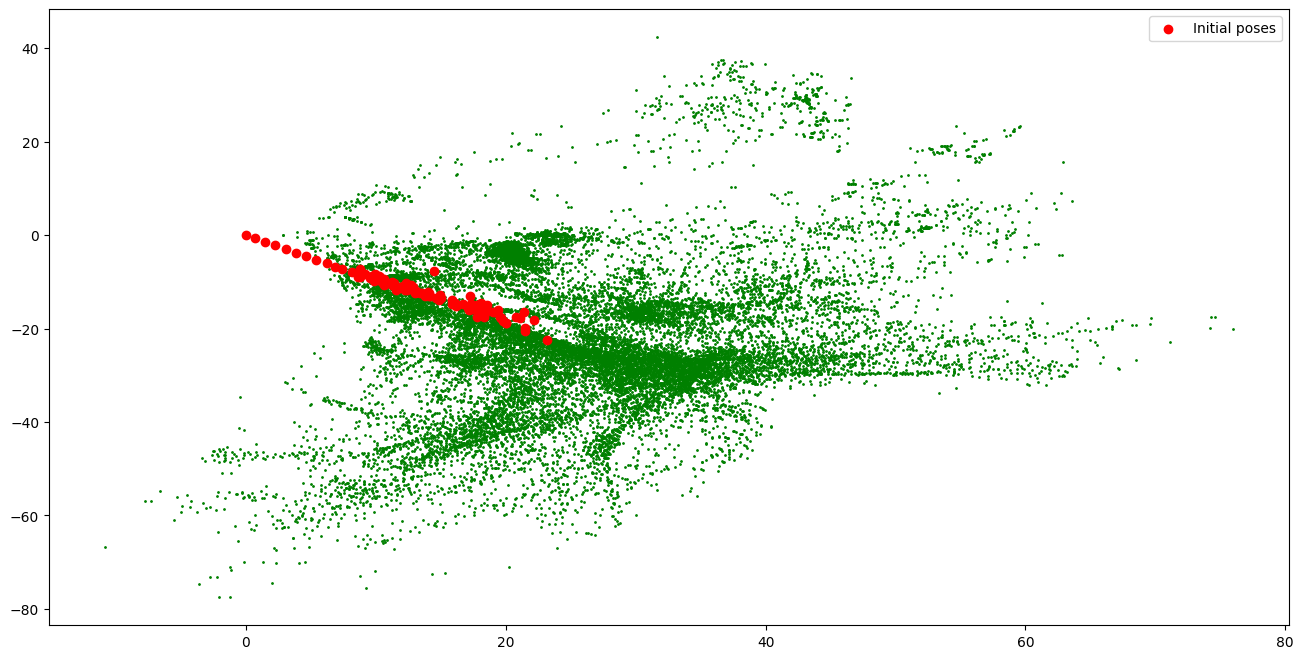

In [154]:
initial_poses = []
final_poses = []
for cam_sym in camera_ids:
  pose_initial = initial_values.atPose3(cam_sym)
  initial_poses.append((pose_initial.translation()[2], -pose_initial.translation()[0])) # OSS: z, -x in camera coordinates becomes x,y in world coordinates if the orientation of the camera is z = forward, x = right, y = downwards
initial_poses = np.array(initial_poses)

points = []
for point_sym in points_ids:
    point = initial_values.atPoint3(point_sym)
    points.append((point[2], -point[0]))
points = np.array(points)

# here we are plotting the original camera poses (pose_initial) and 3D points (point) before we optimize
plt.figure(figsize=(16,8))
plt.scatter(points[:, 0], points[:, 1], c='green', s=1)
plt.scatter(initial_poses[:, 0], initial_poses[:, 1], c='red', label='Initial poses')
plt.legend()

In [136]:
# Optimize
params = gtsam.LevenbergMarquardtParams()
params.setVerbosity("TERMINATION")   # "SILENT", "SUMMARY", "TERMINATION"
params.setVerbosityLM("TERMINATION")   # "SILENT", "SUMMARY", "TERMINATION"
params.setMaxIterations(100)
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_values, params) # see theory
result = optimizer.optimize()
optimizer.print()

converged
errorThreshold: 9063144.82853 <? 0
absoluteDecrease: 0 <? 1e-05
relativeDecrease: 0 <? 1e-05
iterations: 16 >? 100
LevenbergMarquardtOptimizer
  parameters:

relative decrease threshold: 1e-05
absolute decrease threshold: 1e-05
      total error threshold: 0
         maximum iterations: 100
                  verbosity: TERMINATION
         linear solver type: MULTIFRONTAL CHOLESKY
                   ordering: COLAMD
              lambdaInitial: 1e-05
               lambdaFactor: 10
           lambdaUpperBound: 100000
           lambdaLowerBound: 0
           minModelFidelity: 0.001
            diagonalDamping: 0
                minDiagonal: 1e-06
                maxDiagonal: 1e+32
                verbosityLM: TERMINATION


In [137]:
# Calculate average reprojection error (RMSE)
final_error = graph.error(result)
num_factors = graph.size()
rmse = np.sqrt(final_error / num_factors)

print(f"Final Total Error: {final_error:.2f}")
print(f"Number of factors: {num_factors}")
print(f"Average Error (RMSE): {rmse:.4f}")

Final Total Error: 9063144.83
Number of factors: 540305
Average Error (RMSE): 4.0956


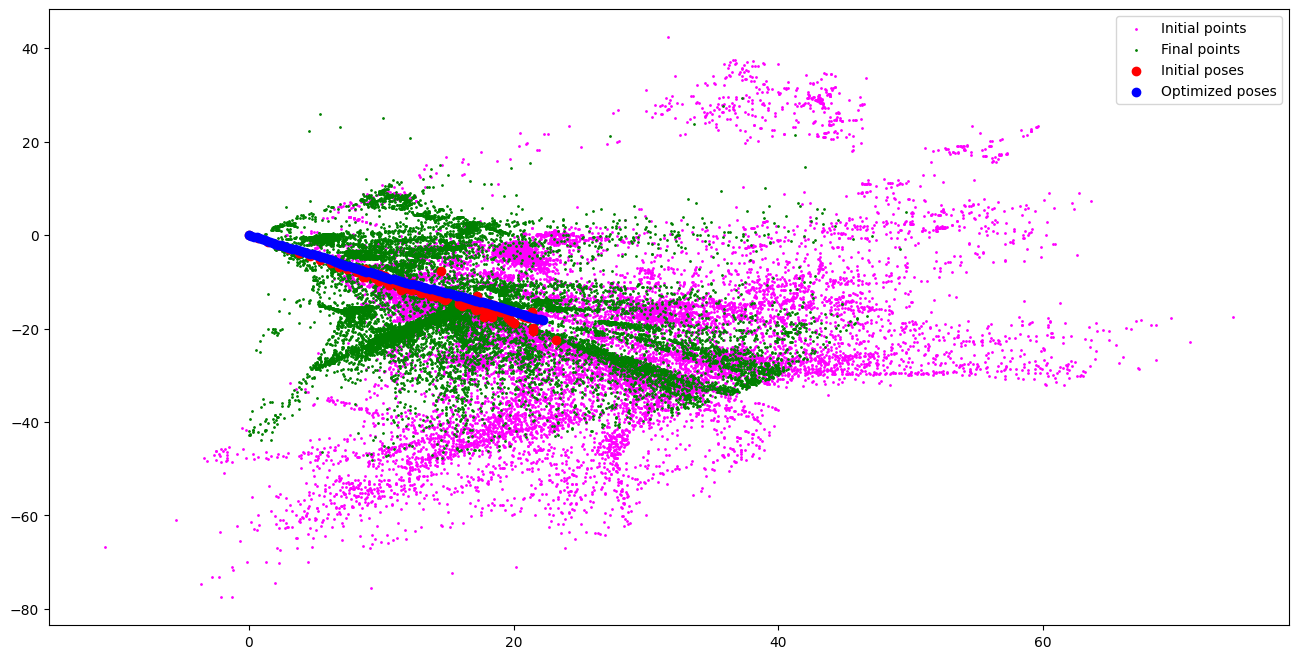

In [138]:
# Keep same scale factor of initial poses
scale = np.linalg.norm(initial_values.atPose3(camera_ids[-1]).translation()) / np.linalg.norm(result.atPose3(camera_ids[-1]).translation())
# explanation: the norm of the position of the last camera is the overall distance covered in a straight line, 
# we can compute the common scale scale factor as the ratio between the distance covered in the first experiement and the 
# distance covered in the result after optimization 

initial_poses = []
final_poses = []
for cam_sym in camera_ids:
  pose_initial = initial_values.atPose3(cam_sym)
  initial_poses.append((pose_initial.translation()[2], -pose_initial.translation()[0])) # same reason as before

  pose_final = result.atPose3(cam_sym)
  final_poses.append((scale*pose_final.translation()[2], -scale*pose_final.translation()[0]))

initial_poses = np.array(initial_poses)
final_poses = np.array(final_poses)


initial_points = []
points = []
for point_sym in points_ids:
    point_initial = initial_values.atPoint3(point_sym)
    point_final = result.atPoint3(point_sym)
    if np.linalg.norm(point_final) > 50/scale or point_final[2] < 0:
      continue
    initial_points.append((point_initial[2], -point_initial[0]))
    points.append((scale*point_final[2], -scale*point_final[0]))
initial_points = np.array(initial_points)
points = np.array(points)

plt.figure(figsize=(16,8))
plt.scatter(initial_points[:, 0], initial_points[:, 1], c='magenta', s=1, label='Initial points')
plt.scatter(points[:, 0], points[:, 1], c='green', s=1, label='Final points')
plt.scatter(initial_poses[:, 0], initial_poses[:, 1], c='red', label='Initial poses')
plt.scatter(final_poses[:, 0], final_poses[:, 1], c='blue', label='Optimized poses')
plt.legend()


In [139]:
# # does not work

# def gtsam_result_to_open3d(result, pose_keys_prefix='c', point_keys_prefix='p'):
#     geometries = []

#     # --- Collect 3D points ---
#     pts = []
#     for key in result.keys():
#         ch = chr(gtsam.Symbol(key).chr())
#         if ch == point_keys_prefix:
#             pt = result.atPoint3(key)
#             if np.linalg.norm(pt) > 100/scale or pt[2] < 0:
#                 continue
#             pts.append([pt[0]*scale, pt[1]*scale, pt[2]*scale])
#     if pts:
#         pts_np = np.array(pts)
#         pcd = o3d.geometry.PointCloud()
#         pcd.points = o3d.utility.Vector3dVector(pts_np)
#         pcd.paint_uniform_color([0.1, 0.7, 0.1])  # green points
#         geometries.append(pcd)

#     # --- Collect camera poses as coordinate frames ---
#     for key in result.keys():
#         ch = chr(gtsam.Symbol(key).chr())
#         if ch == pose_keys_prefix:
#             pose = result.atPose3(key)
#             T = pose.matrix()
#             T[0:3, 3] *= scale
#             frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)
#             frame.transform(T)   # apply pose transform
#             geometries.append(frame)

#     return geometries
# geometries = gtsam_result_to_open3d(result)
# o3d.visualization.draw_geometries(geometries, )
